In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

## Problem Description

This project uses deep learning to classify pathology scans based on if they have indicators of cancer in them. The data comes from the Histopathologic Cancer Detection competition on Kaggle: https://www.kaggle.com/c/histopathologic-cancer-detection. While the competition allows a range of deep learning models, we will use convolutional neural networks (CNN) for our analysis. We will test out a couple of variations on CNNs.

## Data Description & Exploratory Data Analysis

The inputs for modeling are TIF image files in the test and train directories. The sample submission file indicates that we pull the image ID from file names and add an associated 0 or 1 classification label indicating if the center region of an image contains at least one pixel of tumor tissue. The train_labels CSV has training labels matched with file IDs.

In [2]:
df_sample_submission = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
df_train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_ids = os.listdir("/kaggle/input/histopathologic-cancer-detection/train")
test_ids = os.listdir("/kaggle/input/histopathologic-cancer-detection/test")
df_sample_submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [3]:
n_train = len(train_ids)
n_test = len(test_ids)
total_samples = n_train+n_test

print(f'Number of train samples: {n_train:,} -- {n_train/total_samples:.3f} of all the samples')
print(f'Number of test samples: {n_test:,} -- {n_test/total_samples:.3f} of all the samples')

Number of train samples: 220,025 -- 0.793 of all the samples
Number of test samples: 57,458 -- 0.207 of all the samples


In [4]:
print(df_train_labels.shape)
df_train_labels.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


We have about 220,000 train samples and 57,500 test samples, about an 80-20 split. Let's take a look at some sample images to see what we're working with.

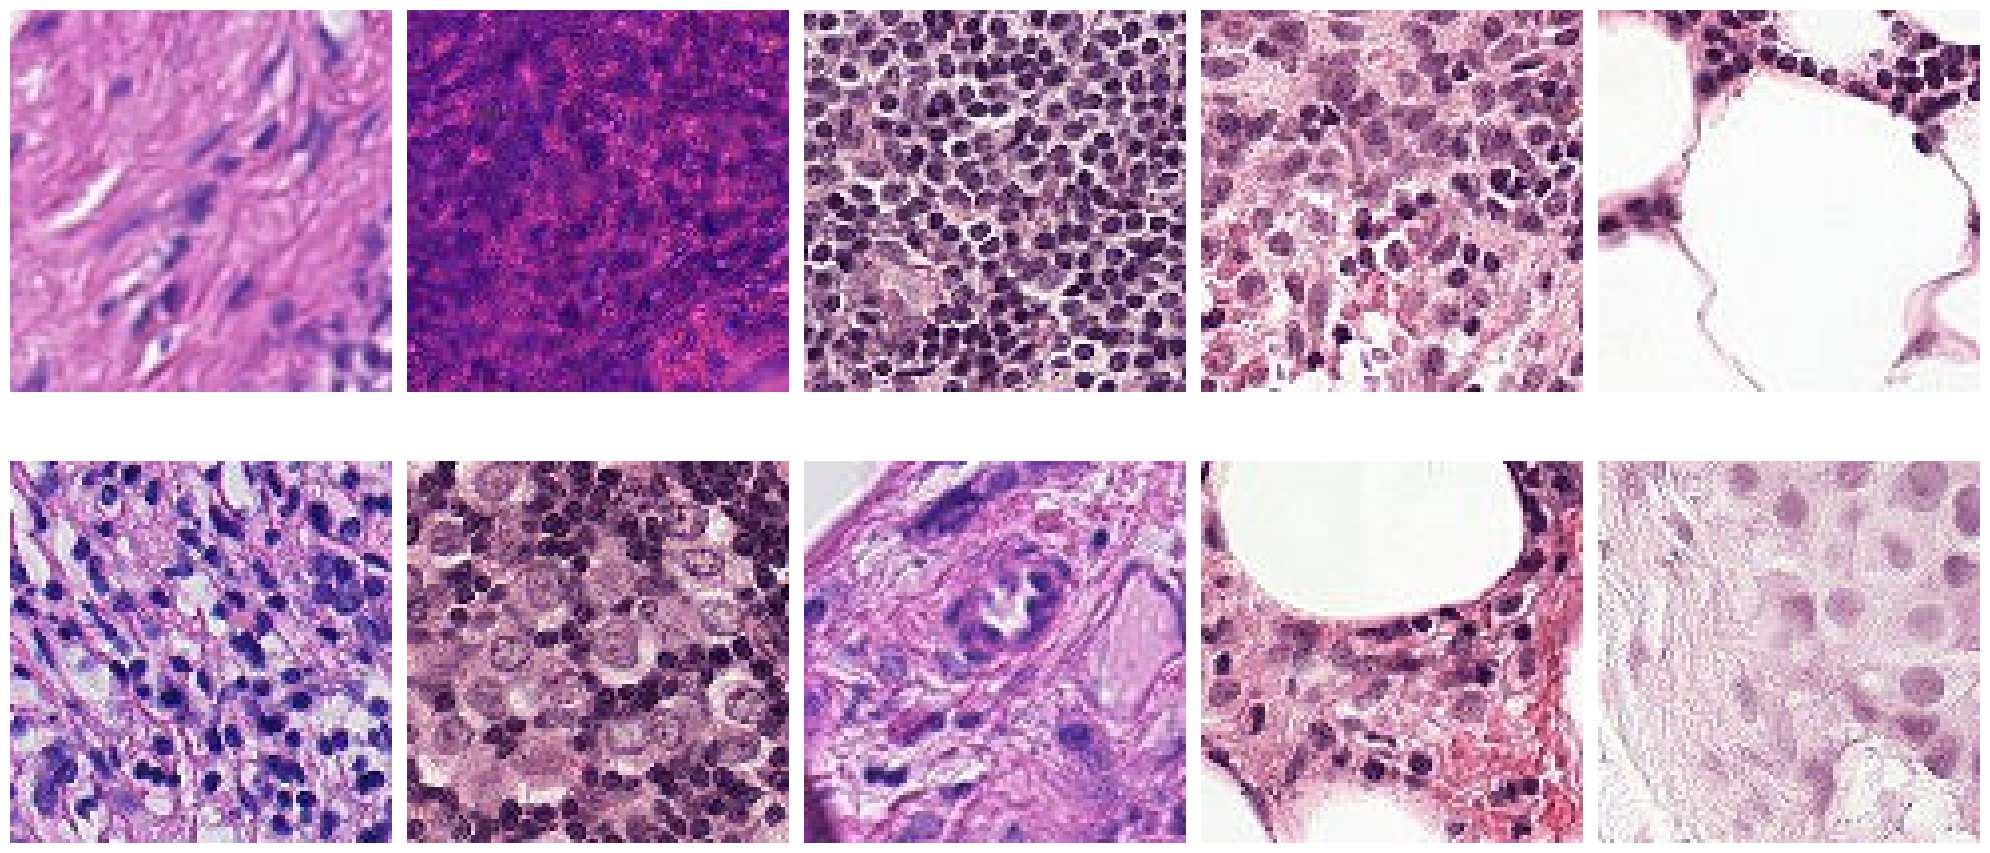

In [5]:
# Set up grid with 2 rows and 5 columns
fig, axes = plt.subplots(
    2
    , 5
    , figsize=(20,10)
)

for i, img in enumerate([
    # Unpacking the lists directly instead of creating an intermediate combined list
    *df_train_labels.loc[df_train_labels['label'] == 0, 'id'].sample(5).tolist() 
    ,*df_train_labels.loc[df_train_labels['label'] == 1, 'id'].sample(5).tolist()
]):
    axes[
        0 if i < 5 else 1 # Row 0 or 1
        , i if i < 5 else i-5 # Col 0 - 5
    # Display TIF image with matplotlib
    ].imshow(Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{img}.tif'))

# Turn axis labels and grids off
for ax in axes.ravel():
    ax.set_axis_off()
    
fig.tight_layout()

In [18]:
print(f'The images have pixel size of: ' \
      f'{Image.open(f"/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[0,0]}.tif").size}'
)

The images have pixel size of: (96, 96)


The top row has images with labels indicating no cancer in the center region of the image. The bottom row has images labeled as having cancer. I'm not able to parse these out visually. Fortunately, we will use the CNNs below to classify for us.

We also see that the size of the image is 96x96 pixels. Below we will confirm that all images have the same size.

Let's see if we have balanced class representation.

Percentage of 0 labels: 0.595
Percentage of 1 labels: 0.405



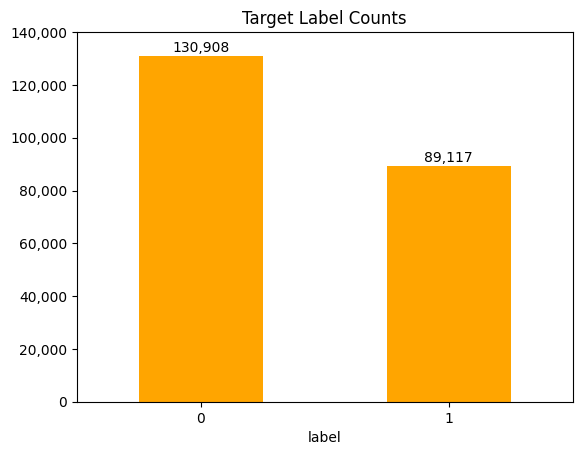

In [7]:
label_counts = df_train_labels.groupby('label').count()
zeros = label_counts.loc[0].values[0]
ones = label_counts.loc[1].values[0]

print(f'Percentage of 0 labels: {zeros/(zeros+ones):.3f}')
print(f'Percentage of 1 labels: {ones/(zeros+ones):.3f}')
print()

ax = label_counts.plot(
    kind='bar'
    , rot=0
    , legend=False
    , color='orange'
    , title='Target Label Counts'
);

ax.bar_label(
    ax.containers[0]
    , fmt='{:,.0f}'
    , padding=1
);

# matplotlib throws a warning if you do not set the axis label values before then 
# reformatting the labels, so this line addresses that issue and quiets the warning
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels([f'{x:,.0f}' for x in ax.get_yticks()]);

We have a 60-40 split for 0-1 label counts. This is not too big of a skew towards the 0s. We will keep an eye out as we dig into further EDA and then modeling in case any other signs of problematic class imbalance pop up, but, for now, I am comfortable moving forward with this split.

Next we will check for missing or invalid values.

In [8]:
# Check nulls
print(f'Number of missing values: {df_train_labels.isnull().sum().sum()}')
print()

# Check that all IDs are a consistent length
print(f'Unique lengths of IDs: { {len(id) for id in df_train_labels["id"]} }')
print()

# Make sure no IDs show up more than once in the label CSV
print(f'Number of unique IDs: {len(df_train_labels["id"].unique()):,}')
print(f'Number of total IDs:  {df_train_labels.shape[0]:,}')
print()

# Check that no train IDs exist in one spot and not the other.We still have the file 
# extension in train_ids but not in the label df, so we strip it out for the next checks
print(f'IDs in train CSV but not in file names: {set(df_train_labels["id"]).difference(set([id[:-4] for id in train_ids]))}')
print(f'IDs in file names but not in train CSV: {set([id[:-4] for id in train_ids]).difference(set(df_train_labels["id"]))}')
print()

# Check that we only have 0s and 1s for labels
print(f'Unique target labels: {df_train_labels.label.unique()}')
print()

# Check image sizes -- this can take awhile, but it will tell us if we need dynamic checks
# for size during modeling or if all the files have the same pixel size. Since this takes
# so long to run, I put the output below each print statement and will comment the print
# statements out unless we need to rerun them for any reason.
#
# print(f'Unique train image sizes: ' 
#     f'{ {Image.open(f"/kaggle/input/histopathologic-cancer-detection/train/{img}").size for img in train_ids} }'
# )
#
# Output
# Unique train image sizes: {(96, 96)}

# print(f'Unique test image sizes: ' \
#     f'{ {Image.open(f"/kaggle/input/histopathologic-cancer-detection/test/{img}").size for img in test_ids} }'
# )
#
# Output
# Unique test image sizes: {(96, 96)}

Number of missing values: 0

Unique lengths of IDs: {40}

Number of unique IDs: 220,025
Number of total IDs:  220,025

IDs in train CSV but not in file names: set()
IDs in file names but not in train CSV: set()

Unique target labels: [0 1]



We have no missing values in either columns. All of the IDs are 40 characters long, there are no duplicate IDs in the train CSV, and there are no IDs in the training label CSV or in the training file names that do not exist in the other. We only have 0s and 1s for labels. All of the inputs look like they are present and valid.

The lines that are commented out at the end check that each train and test file has the same 96x96px dimensions. This means the modeling will not need to dynamically adjust to different image sizes.

Scanning the list of IDs, it does look like they may be somewhat sequential rather than fully unique such as with UUIDs. We will also check that there are no patterns of clusters of nearby IDs that all have 0s or 1s.

The next code block is what I used to explore different chunks of ID ranges. The problem is that the dataset is big enough that we see two solid lines at 0 and 1 when looking at the whole dataset at once. I then tried smaller ranges. Around a range of 500, you can see some missing spots, typically for 1s, but there does not seem to be a pattern. I ended up doing some spot checking, but I was not able to find a programmatic way to display plots with enough detail to be useful without breaking the notebook due to displaying too many plots.

I will display a sample plot and keep the main code commented out. I was unable to find any index-series patterns related to labeling.

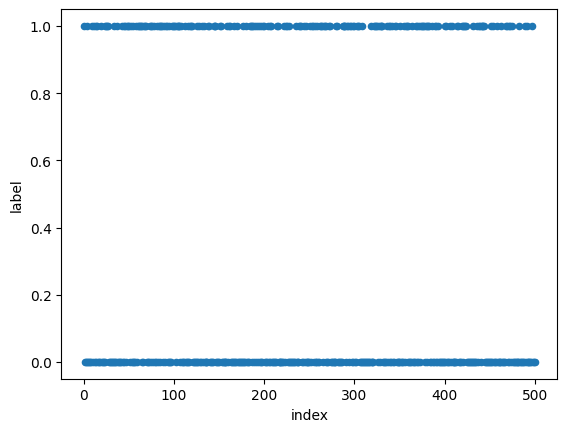

In [9]:
# for i in range(0, df_train_labels.shape[0], 500):
#     if df_train_labels.shape[0] - i < 500:
#         df_train_labels.sort_values('id', ignore_index=True).reset_index().loc[-500:].plot(kind='scatter', x='index', y='label', use_index=True);
#     df_train_labels.sort_values('id', ignore_index=True).reset_index().loc[i:i+500].plot(kind='scatter', x='index', y='label', use_index=True);

df_train_labels.sort_values('id', ignore_index=True).reset_index().loc[0:500].plot(kind='scatter', x='index', y='label', use_index=True);

## Modeling

This project explores using CNNs to classify the images. CNNs are feed-forward neural networks that use backpropagation to adjust the weights, the weights in CNNs being the parameter values in the kernels. The core idea with CNNs is that we apply kernels or filters -- nxm rectangular windows -- that slide along different dimensions of the input images, summarizing or abstracting elements of the image. When we add multiple kernels in a layer, each kernel picks up on a different aspect or feature in the image. When we add multiple layers into the model, each successive layer picks up on higher levels of abstraction, combining features found in previous layers. 

The specific requirement for this competition is to identify if there is at least one pixel of cancerous tumor tissue in the center 32x32px region of each image. We will use binary cross-entropy (BCE) for the loss function to measure how far our predictions are from the ground truth labels. We could look at other loss functions while improving performance, but this would be one of the last changes I would look at since BCE is a reliable standard for binary classification problems.

We will stick with one node in the output layer that uses a sigmoid activation function since we are dealing with binary classification for the output. This is not something we will change while improving on the model since we need a binary output.

We will use rectified linear units (ReLU) activation functions for all of the nodes in the hidden layers. ReLU helps to avoid the vanishing gradient issue we run into with sigmoid or tanh activation functions in hidden layers. The vanishing gradient problem occurs because sigmoid and tanh functions work well around the midpoints of their inputs, but they flatten out towards the larger and smaller ends of their inputs. This flattening out means the gradient drops to increasingly smaller amounts, making optimization through backpropagation difficult.

And speaking of backpropagation, we can guess based on general observations of base stocastic gradient descent (SGD) that we need to add elements like momentum or decay to adjust the learning rate during training, but that still will not perform as well as more advanced optimization algorithms. We will instead start with adaptive moment estimation (Adam). A quick scan over optimization recommendations hint that Adam is a good starting point. Adam uses the first and second moments of the gradients to inform learning rate updates. Adam is more complex than something like setting a static or simple momentum or decay parameter. Optimization algorithm is one hyperparameter we may want to explore depending on what we see during modeling.

Finally, getting to the CNN architecture itself, we will need to keep the scope of options narrow since there are a lot of hyperparameters that we can play with.



Items we could test out in future iterations
- Different loss functions (not the first change to test out)
- Start with different pre-trained models
- Optimization algorithm
- Width and depth of hidden layers

Working ideas for CNN (will return to these after some exploratory modeling)
- Base CNN
- CNN with different size filters
- CNN with padding
- CNN with stride
- CNN with pooling
- CNN with dropout regularization
- CNN with batch normalization
- Pre-trained CNN

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    df_train_labels['id']
    , df_train_labels['label']
    , test_size=0.2
    , random_state=8675309
)

Next we need to isolate the 32x32px center of the image. We will crop each image down to just the central region we need.

PIL coordinate system with (0,0) in the upper left. We then need to calculate the upper-left and bottom-right corners of the cropped rectangle.

The base images have 96 pixels in each dimension. We need to remove 32 pixels from both dimensions to set aside the cropped area we are keeping. 96-32=64 pixels that we need to remove in each dimension. We then half that since the cropped area is symmetric around the center lines in each dimension. 64/2=32 pixels from each border towards the center to reach the boundary for the remaining cropped image.

This leaves us with the following corners for the 32x32px cropped area in the center
- ul = (32, 32)
- ur = (64, 32)
- br = (64, 64)
- bl = (32, 64)

(96, 96)


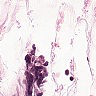

In [24]:
print(Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[1,0]}.tif').size)
Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[1,0]}.tif')

(32, 32)


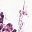

In [25]:
print(Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[1,0]}.tif').crop(
    (
        32, 32 # Upper-left corner
        , 64, 64 # Bottom-right corner
    )
).size)
Image.open(f'/kaggle/input/histopathologic-cancer-detection/train/{df_train_labels.iloc[1,0]}.tif').crop(
    (
        32, 32 # Upper-left corner
        , 64, 64 # Bottom-right corner
    )
)

## Modeling Results Summary

## Conclusion